# Решение контеста [Higgs Boson Machine Learning Challenge](https://www.kaggle.com/c/higgs-boson)

Автор: Дёгтев Иван

Частично используется код из [Python starting kit](http://higgsml.lal.in2p3.fr/starting-kit/)

## Введение

Описание конкурса изложено по [этой ссылке](https://higgsml.lal.in2p3.fr/documentation/). Общий смысл задачи: классификация событий на два класса: сигнал и фон. Событие описывается двумя видами параметров: первычными и производными. Первые параметры в каком-то смысле являются прямыми измеряемыми величинами эксперимента. Вторая группа состоит из величин, которые считаются из значений первой группы и которые согласно теории должны играть ключевую роль для выявления конкретного сигнала.

Для начала опишем способ решения этой задачи без использования машинного обучения. Общий формализм можно, например, найти в статье ["Asymptotic formulae for likelihood-based tests of new physics"](https://arxiv.org/abs/1007.1727). Для начала выбирается нулевая гипотеза (шум), по которой (с помощью Монте-Карло или теоретических методов) фиксируется распределение экспериментально наблюдаемых величин. Затем выбирается альтернатива (шум плюс сигнал) и также находится распределения величин. После этого с помощью известных статистических критериев (Неймана-Пирсона или максимума правдоподобия в общем случае) находится уровень значимости разных событий. 

Проблема этого метода возникает при тестировании гипотез. Дело в том, что сигнальные события происходят очень редко и необходима огромная выборка, чтобы протестировать гипотезу с достаточным уровнем значимости. При этом большую часть выборки будут составлять фоновые события. Подсчёт же критерия как правило требует оптимизации величины (например, максимизации правдоподобия) с учетом знания, какие события являются фоновыми, а какие нет. Поэтому без методов машинного обучения (или их элементарных аналогов) проверка критерия заставила бы делать огромный подсчёт, перебирающий все комбинации предположений, какие события являются фоновыми, а какие сигнальными. 

Для машинного обучения же эта задача выглядит довольно стандартной задачей классификации. Кроме того, задача не требует жестких рамок по качеству. Мы, например, не могли бы использовать обычные методы машинного обучения для предсказания уровня статистической значимости, поскольку эти методы, как правило, не имеют за собой доказанных теоретических гарантий. Вместо этого, машинное обучения пытается улучшить качество какой-то метрики (в нашем случае AMS). Машинное обучение успешно справляется с такой задачей и далее будет показано, как это происходит.

## Анализ

### Описание моделей

Я выбрал следующие методы: случайный лес и градиентный бустинг. Первый даёт очень хороший результат после совершения очень малых усилий. Поэтому на нём удобно ставить для себя какой-то референсный балл. Второй метод был выбран, как один из самых продвинутых методов неглубокого обучения, за счёт которого в общем-то и был установлен Benchmark в 3.4, который мы будем пытаться улучшить. Кроме того второе место на конкурсе было достигнуто за счёт бустинга (хотя и более сложного), а первое и третье с помощью нейронных сетей, которые в данном анализе я использовать не буду.

### Оптимизация AMS

Оптимизация AMS будет проводиться в два этапа. Для этого вся выборка, для которой известны ответы, будет поделена на 90% тренировочной выборки и 10% валидационной выборки. 

Первый этап оптимизации будет применяться для выбора параметров модели (таких, как глубина дерева). Для этого будет использоваться подход, описанный командой, занявшей 9-ое место на конкурсе [ссылка](http://www.jmlr.org/proceedings/papers/v42/diaz14.pdf). Суть подхода в попытке максимизировать взвешенный AUC на кросс-валидации. Вообще говоря, данный подход является во многом эврестическим. ([другой способ](www.jmlr.org/proceedings/papers/v42/cowa14.pdf) - максимизация взвешенной ошибки, но он не сильно меняет результат). 

После выбора параметров, модель будет обучена на всей тренировочной выборке и затем начнётся второй этап оптимизации. Он состоит в выборе порога. Для этого для всей валидационной выборки будет предсказана вероятность принадлежности к классу "сигнала". После этого будет подобран порог вероятности, начиная с которого событие будет отнесено к сигналу, за счёт максимизации метрики AMS. Этот метод менее эврестический, поскольку он использует настоящую метрику (для него по идее даже [доказаны](http://arxiv.org/abs/1412.2106) некоторые теоретические гарантии по точности, которые, правда, напрямую не применимы для подхода, который буду использовать я).

Измерять качество моделей мы будем при выборе порога, поскольку он будет происходить на валидационной выборке, отличной от той, на которой училась модель. Чтобы уточнить такую оценку, можно было бы использовать кросс-валидацию и проводить процедуру несколько раз на разных разбиениях тренировочной/валидационной выборки, но это занимало бы слишком много времени для нашего анализа. К тому же конкурс уже закончился и мы не ограничены в отправке файлов, поэтому проверять результаты можно прямо на странице конкурса.

Теперь начнём, собственно, сам анализ.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
import csv

Сначала напишем функцию, которая читает все данные и возвращает информацию в разделённых переменных (id, веса, признаки и целевую переменную для случая учебной выборки; id и признаки для тестовый выборки). 

In [3]:
def read_data(filename, read_train=False):
    data = pd.read_csv(filename)
    if read_train:
        data.loc[data['Label']=='s', 'Label']= 1
        data.loc[data['Label']=='b', 'Label']= -1
        data['Label'] = data['Label'].astype('int64')
        y = data['Label'].as_matrix()
        del  data['Label']    
        
        weights = data['Weight'].as_matrix()
        del  data['Weight']
        
    ids = data['EventId'].as_matrix()
    del  data['EventId']        
    
    X = data.as_matrix()
    
    if read_train:
        return ids, weights, X, y
    return ids, X

Теперь воспользуемся нашей функцией и прочитаем тренировочную информацию.

In [4]:
ids, weights, X_train, y_train = read_data("training.csv", read_train=True)

Разделим тренировочную выборку на 90% для обучения модели и 10% для оптимизации порога AMS.

In [5]:
from sklearn.cross_validation import train_test_split

In [6]:
ids_train, ids_validation, weights_train, weights_validation, X_train, X_validation, y_train, y_validation = \
    train_test_split(ids, weights, X_train, y_train, test_size=0.1, random_state=23, stratify=y_train)

### Random forest

Попробуем теперь обучить пробный случайный лес без оптимизаций параметров, чтобы посмотреть, какое качество это даст.

In [7]:
from sklearn.ensemble import RandomForestClassifier

In [8]:
rnd_frst = RandomForestClassifier(n_estimators=1000,
                                  n_jobs=-1,
                                  random_state=0
                                 )
rnd_frst.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

Теперь напишем пару функций для оптимизации порога AMS на валидационной выборке.

In [9]:
def AMS(s,b):
    assert s >= 0
    assert b >= 0
    bReg = 10.
    return math.sqrt(2 * ((s + b + bReg) * 
                          math.log(1 + s / (b + bReg)) - s))

In [10]:
def find_threshold(scores_validation, w_factor, s_selector_validation, b_selector_validation, weights_validation):
    s = np.sum(weights_validation[s_selector_validation])
    b = np.sum(weights_validation[b_selector_validation])
    tIIs = scores_validation.argsort()
    amss = np.empty([len(tIIs)])
    ams_max = 0
    threshold = 0.0
    for tI in range(len(tIIs)):
        # don't forget to renormalize the weights to the same sum 
        # as in the complete training set
        amss[tI] = AMS(max(0,s * w_factor),max(0,b * w_factor))
        if amss[tI] > ams_max:
            ams_max = amss[tI]
            threshold = scores_validation[tIIs[tI]]
            #print tI,threshold
        if s_selector_validation[tIIs[tI]]:
            s -= weights_validation[tIIs[tI]]
        else:
            b -= weights_validation[tIIs[tI]]   
    return amss, threshold

In [11]:
probas = rnd_frst.predict_proba(X_validation)[:, 1]
amss, forest_threshold = find_threshold(scores_validation=probas,
                                w_factor=1.* (X_train.shape[0] + X_validation.shape[0]) / float(X_validation.shape[0]),
                                s_selector_validation=(y_validation==1),
                                b_selector_validation=(y_validation==-1),
                                weights_validation=weights_validation
                               )

 Max AMS =  3.41725188894
Threshold =  0.793


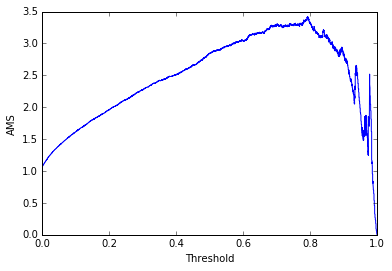

In [13]:
print "Max AMS = ", amss.max()
print "Threshold = ", forest_threshold
plot(np.sort(probas), amss)
xlabel('Threshold')
ylabel('AMS')

Видно, что случайный лес даёт неплохой результат ~3.4 на валидационной выборке. Посмотрим, насколько это значение изменится на private leaderboard. Для этого напишем функцию для сохранения результата.

In [14]:
ids_test, X_test = read_data("test.csv")

In [15]:
forest_test_scores = rnd_frst.predict_proba(X_test)[:,1]

In [16]:
def write_submission(Ids, Scores, Threshold, Filename):
    testInversePermutation = Scores.argsort()
    
    testPermutation = list(testInversePermutation)
    for tI,tII in zip(range(len(testInversePermutation)),
                      testInversePermutation):
        testPermutation[tII] = tI
        
    submission = np.array([[str(Ids[tI]),str(testPermutation[tI]+1),
                       's' if Scores[tI] >= Threshold else 'b'] 
            for tI in range(len(Ids))])
    
    submission = np.append([['EventId','RankOrder','Class']],
                        submission, axis=0)
    
    np.savetxt(Filename, submission, fmt='%s', delimiter=',')

In [17]:
write_submission(ids_test, forest_test_scores, forest_threshold, "random_forest_thershold.csv")

Данный файл показывает 3.43567 на public и 3.38861 на private. 

### Grid Random Forest

Теперь попробуем немного улучшить результат за счёт более тонкой настройки леса. Поиск будет осуществляться по всей решётке.

Так как в методе оптимизации используется оценка взвешенного AUC, то придётся писать свою функцию для поиска оптимальных параметров на решётке (функции из sklearn вроде GridSearchCV плохо работают с весами на выборке).

In [18]:
from sklearn.grid_search import ParameterGrid
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import roc_auc_score

In [19]:
def random_forest_grid_search(X, y, weights, parameters, cv=5):
    param_grid = ParameterGrid(parameters)
    skfold = StratifiedKFold(y, n_folds=cv, shuffle=True, random_state=23)
    max_score = 0.
    best_params = dict()
    for args in list(param_grid):
        print "Fitting ", args
        print "Scores: ",
        scores = list()
        for train_indices, test_indices in skfold:
            estimator = RandomForestClassifier(n_estimators=100,
                                               n_jobs=-1,
                                               random_state=0,
                                               **args
                                              )
            estimator.fit(X[train_indices], y[train_indices])
            probas = estimator.predict_proba(X[test_indices])[:, 1]
            scores.append(roc_auc_score(y_true=y[test_indices], 
                                        y_score=probas, 
                                        sample_weight=weights[test_indices]))
            print scores[-1],
        new_score = np.mean(scores)
        print
        print "Mean: ", new_score, " Std: ", np.std(scores)
        if new_score > max_score:
            max_score = new_score
            best_params = args
    best_estimator = RandomForestClassifier(n_estimators=1000,
                                               n_jobs=-1,
                                               random_state=0,
                                               **best_params
                                              )
    best_estimator.fit(X, y)
    return best_estimator

Также необходимо не забыть уравнять веса так, чтобы априорная вероятность сигнала и априорная вероятность фона были одинаковыми.

In [20]:
balanced_weights_train = np.copy(weights_train)
balanced_weights_train[y_train==1] = 0.5*balanced_weights_train[y_train==1]/float(balanced_weights_train[y_train==1].sum())
balanced_weights_train[y_train==-1] = 0.5*balanced_weights_train[y_train==-1]/float(balanced_weights_train[y_train==-1].sum())

В качестве параметров оптимизации выберем 'max_depth' и 'min_samples_leaf'. Заметим, что при поиске на решётке обучается лес размером в 100 деревьев, а после выбора лучших параметров обучается лес в 1000 деревьев. То есть мы используем тенденцию леса не терять качество при увеличении количества деревьев.

In [21]:
parameters = {'max_depth': np.logspace(2, 4, 3),
              'min_samples_leaf': np.linspace(1, 10, 5)
             }
best_random_forest = random_forest_grid_search(X_train, y_train, balanced_weights_train, parameters, cv=5)

Fitting  {'max_depth': 100.0, 'min_samples_leaf': 1.0}
Scores:  0.923512134859 0.926682477726 0.927490464617 0.926350620137 0.927641335537
Mean:  0.926335406575  Std:  0.0014920564702
Fitting  {'max_depth': 100.0, 'min_samples_leaf': 3.25}
Scores:  0.925471075448 0.928122198792 0.928828858439 0.928829255237 0.929278433039
Mean:  0.928105964191  Std:  0.00136845251868
Fitting  {'max_depth': 100.0, 'min_samples_leaf': 5.5}
Scores:  0.926007268561 0.928857324522 0.929752446791 0.929481423023 0.929826286159
Mean:  0.928784949811  Std:  0.00143012292877
Fitting  {'max_depth': 100.0, 'min_samples_leaf': 7.75}
Scores:  0.92636094167 0.929245615795 0.930047939126 0.929522738954 0.93035580136
Mean:  0.929106607381  Std:  0.00142672772958
Fitting  {'max_depth': 100.0, 'min_samples_leaf': 10.0}
Scores:  0.926610517738 0.929412389907 0.930361941617 0.929577239271 0.930216406975
Mean:  0.929235699102  Std:  0.00136159147014
Fitting  {'max_depth': 1000.0, 'min_samples_leaf': 1.0}
Scores:  0.92351213

In [22]:
probas = best_random_forest.predict_proba(X_validation)[:, 1]
amss, best_forest_threshold = find_threshold(scores_validation=probas,
                                w_factor=1.* (X_train.shape[0] + X_validation.shape[0]) / float(X_validation.shape[0]),
                                s_selector_validation=(y_validation==1),
                                b_selector_validation=(y_validation==-1),
                                weights_validation=weights_validation
                               )

Max AMS =  3.51375077762
Threshold =  0.785345568141


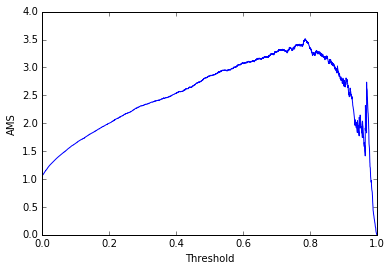

In [23]:
print "Max AMS = ", amss.max()
print "Threshold = ", best_forest_threshold
plot(np.sort(probas), amss)
xlabel('Threshold')
ylabel('AMS')

Видим, что качество улучшилось на нашей валидационной выборке. Посмотрим, что даст это решение на private.

In [24]:
ids_test, X_test = read_data("test.csv")

In [25]:
best_forest_test_scores = best_random_forest.predict_proba(X_test)[:,1]

In [26]:
write_submission(ids_test, best_forest_test_scores, best_forest_threshold, "random_forest_grid_threshold.csv")

Если загрузить этот файл на kaggle, то результат будет следующим:

- public - 3.46284
- private - 3.47356

Таким образом случайный лес побил MultiBoost Benchmark, для которого
- public - 3.34085
- private - 3.40488

### XGBoost

Попробуем теперь использовать бустинг. Для этого выберем XGBoost и проделаем примерно те же самые действия, что и с лесом: для начала обучим со стандартными параметрами, а затем попробуем их несколько пооптимизировать.

In [27]:
import xgboost as xgb

In [28]:
xgb_classifier = xgb.XGBClassifier(
                     n_estimators=3000,
                     nthread=4,
                     seed=23).fit(X_train, y_train)

In [29]:
probas = xgb_classifier.predict_proba(X_validation)[:, 1]
amss, xgb_threshold = find_threshold(scores_validation=probas,
                                w_factor=1.* (X_train.shape[0] + X_validation.shape[0]) / float(X_validation.shape[0]),
                                s_selector_validation=(y_validation==1),
                                b_selector_validation=(y_validation==-1),
                                weights_validation=weights_validation
                               )

Max AMS =  3.36613914813
Threshold =  0.835897


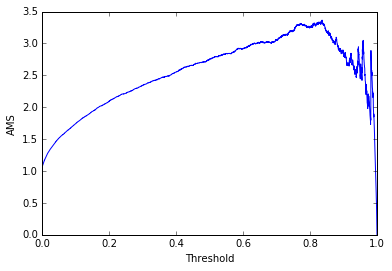

In [30]:
print "Max AMS = ", amss.max()
print "Threshold = ", xgb_threshold
plot(np.sort(probas), amss)
xlabel('Threshold')
ylabel('AMS')

In [31]:
xgb_test_scores = xgb_classifier.predict_proba(X_test)[:,1]

In [32]:
write_submission(ids_test, xgb_test_scores, xgb_threshold, "xgb_threshold.csv")

Бустинг без оптимизации параметров даёт не очень хороший результат на валидационной выборке. В kaggle он показывает:

- public - 3.35950
- private - 3.46353

Это также бьёт порог MultiBoost Benchmark, хотя и несильно.

### Grid XGBoost

Теперь напишем функцию для решёточного поиска для XGBoost (можно было изначально написать более гибкую функцию, в которую классификатор подаётся, как параметр, но это привело бы к ненужным в нашем простом анализе заморочкам).

In [33]:
def xgb_grid_search(X, y, weights, parameters, cv=5):
    param_grid = ParameterGrid(parameters)
    skfold = StratifiedKFold(y, n_folds=cv, shuffle=True, random_state=23)
    max_score = 0.
    best_params = dict()
    for args in list(param_grid):
        print "Fitting ", args
        print "Scores: ",
        scores = list()
        for train_indices, test_indices in skfold:
            estimator = xgb.XGBClassifier(
                             learning_rate =0.1,
                             n_estimators=100,
                             gamma=0,
                             subsample=0.8,
                             colsample_bytree=0.8,
                             objective= 'binary:logistic',
                             nthread=4,
                             scale_pos_weight=1,
                             seed=23,
                             **args
                            ).fit(X[train_indices], y[train_indices])
            probas = estimator.predict_proba(X[test_indices])[:, 1]
            scores.append(roc_auc_score(y_true=y[test_indices], 
                                        y_score=probas, 
                                        sample_weight=weights[test_indices]))
            print scores[-1],
        new_score = np.mean(scores)
        print
        print "Mean: ", new_score, " Std: ", np.std(scores)
        if new_score > max_score:
            max_score = new_score
            best_params = args
    best_estimator = xgb.XGBClassifier(
                             learning_rate =0.1,
                             n_estimators=100,
                             gamma=0,
                             subsample=0.8,
                             colsample_bytree=0.8,
                             objective= 'binary:logistic',
                             nthread=4,
                             scale_pos_weight=1,
                             seed=23,
                             **best_params
                            ).fit(X, y)
    return best_estimator

В качестве параметров оптимизации выберем "древесные" параметры: 'max_depth', 'min_child_weight'. Также заметим, что теперь выбор параметров и обучении "лучшей" модели использует одно и то же количество деревьев (100).

In [34]:
parameters = {'max_depth': np.linspace(3, 15, 5).astype('int64'),
              'min_child_weight': np.linspace(1, 10, 2).astype('int64')
             }
best_xgb = xgb_grid_search(X_train, y_train, balanced_weights_train, parameters, cv=5)

Fitting  {'max_depth': 3, 'min_child_weight': 1}
Scores:  0.920193581216 0.923366443278 0.923699670099 0.922573913684 0.92386740254
Mean:  0.922740202163  Std:  0.0013487970529
Fitting  {'max_depth': 3, 'min_child_weight': 10}
Scores:  0.920193939537 0.923662269483 0.923523891258 0.923224590673 0.923907108578
Mean:  0.922902359906  Std:  0.00137205373386
Fitting  {'max_depth': 6, 'min_child_weight': 1}
Scores:  0.926286727703 0.930150466774 0.931482891299 0.92973679974 0.930763571511
Mean:  0.929684091405  Std:  0.0017979612138
Fitting  {'max_depth': 6, 'min_child_weight': 10}
Scores:  0.926643113204 0.930069035712 0.93138900068 0.929788911842 0.930522756437
Mean:  0.929682563575  Std:  0.0016134919189
Fitting  {'max_depth': 9, 'min_child_weight': 1}
Scores:  0.92715080738 0.930885906747 0.931792880261 0.930432738034 0.9310803533
Mean:  0.930268537144  Std:  0.0016193216761
Fitting  {'max_depth': 9, 'min_child_weight': 10}
Scores:  0.927248549505 0.930917428679 0.932398834687 0.9307573

In [35]:
probas = best_xgb.predict_proba(X_validation)[:, 1]
amss, best_xgb_threshold = find_threshold(scores_validation=probas,
                                w_factor=1.* (X_train.shape[0] + X_validation.shape[0]) / float(X_validation.shape[0]),
                                s_selector_validation=(y_validation==1),
                                b_selector_validation=(y_validation==-1),
                                weights_validation=weights_validation
                               )

Max AMS =  3.37842986047
Threshold =  0.80511


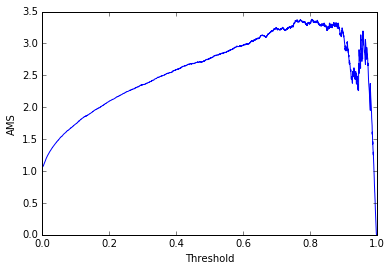

In [36]:
print "Max AMS = ", amss.max()
print "Threshold = ", best_xgb_threshold
plot(np.sort(probas), amss)
xlabel('Threshold')
ylabel('AMS')

На валидационной выборке лучший на решётке классификатор показывает не такой уж хороший результат, проигрывая даже обычному случайному лесу без оптимизации параметров. Всё же посмотрим, каков будет результат на kaggle.

In [37]:
best_xgb_test_scores = best_xgb.predict_proba(X_test)[:,1]

In [38]:
write_submission(ids_test, best_xgb_test_scores, best_xgb_threshold, "xgb_grid_threshold.csv")

После загрузки получаем следующий результат:

- public - 3.47262
- private - 3.53444

Удивительным образом, это много лучше, чем результат на валидационной выборке и лучше, чем все остальные результаты, полученные до сих пор.

Наконец, попробуем усреднить результаты лучшего леса и лучшего бустинга и посмотреть, что из этого выйдет.

In [39]:
write_submission(ids_test, 
                 (best_xgb_test_scores + best_forest_test_scores)/2., 
                 (best_forest_threshold + best_xgb_threshold)/2., 
                 "xgb_plus_forest_threshold.csv")

Несмотря на то, что усреднение производилось самым прямым способом, без всякой оптимизации порога, решение дало улучшение качества:

- public - 3.47804
- private - 3.58769

## Итоги

В итоге мы получаем следующие результаты:

|              | MultiBoost Benchmark | Random forest | Random forest grid | XGBoost | XGBoost grid | Two best average |
|--------------|----------------------|---------------|--------------------|---------|--------------|------------------|
|**Validation**|                      | 3.41725       | **3.51375**        | 3.36614 | 3.37843      |                  |
| **Public**   | 3.34085              | 3.43567       | 3.46284            | 3.35950 | 3.47262      | **3.47804**      |
| **Private**  | 3.40488              | 3.38861       | 3.47356            | 3.46353 | 3.53444      | **3.58769**      |

То же самое удобно изобразить на графике.

([<matplotlib.axis.XTick at 0x10f70240>,
 <a list of 6 Text xticklabel objects>)

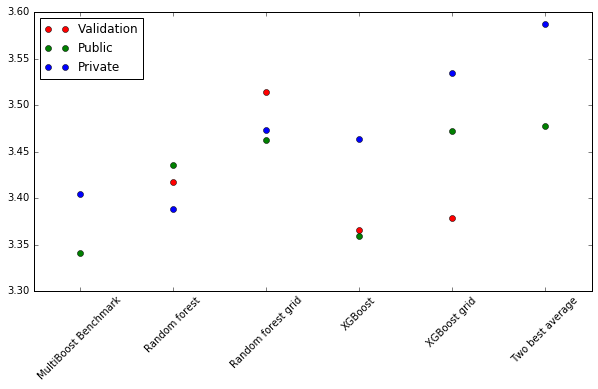

In [57]:
validation_scores = np.array([3.41725, 3.51375, 3.36614, 3.37843])
public_scores = np.array([3.34085, 3.43567, 3.46284, 3.35950, 3.47262, 3.47804])
private_scores = np.array([3.40488, 3.38861, 3.47356, 3.46353, 3.53444, 3.58769])
figure(figsize=(10, 5))
plot(range(1, 5), validation_scores, 'ro', range(6), public_scores, 'go', range(6), private_scores, 'bo')
xlim([-0.5, 5.5])
legend(["Validation", "Public", "Private"], loc='upper left')

labels = ["MultiBoost Benchmark", "Random forest", "Random forest grid", "XGBoost", "XGBoost grid", "Two best average"]
xticks(range(6), labels, rotation=45)

Этих оценок достаточно для простого анализа. Всё же остаётся ещё много методов, которые могут улучшить результат и которые до сих пор не были упомянуты. Я перечислю три метода, которые на мой взгляд могут дать наибольший прирост в качестве:
- более широкий поиск параметров моделей
- работа с признаками (отбор признаков, введение новых признаков)
- использование другой метрики на первом этапе оптимизации AMS